In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

from tools import *

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from minisom import MiniSom

import gc

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/som')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']

# Helper Functions

In [2]:
def plot_som_results(som_x, som_y, win_map, save_path=None):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0), c="red", linewidth=0.5)
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
        
    plt.show()
    
def plot_unscaled_clusters(labels, nclusters, flows_dict, columns, save_path=None, yscale={}):
    """Plot cluster of the original data (not scaled)"""  
    
    fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(5*len(columns), 4*(nclusters)))
    
    print(axs.shape)
    
    for cluster_id, cluster in labels.items():
        for filename in cluster:
            for col_pos, col in enumerate(columns):
                ax = axs[(cluster_id-1, col_pos)]
                ax.plot(flows_dict[filename][col], linewidth=0.5)
                ax.set(ylabel=col, title=f'Cluster {cluster_id}', yscale=yscale.get(col, 'linear'))
                
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    
    plt.show()
      


# Load data

In [4]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])    

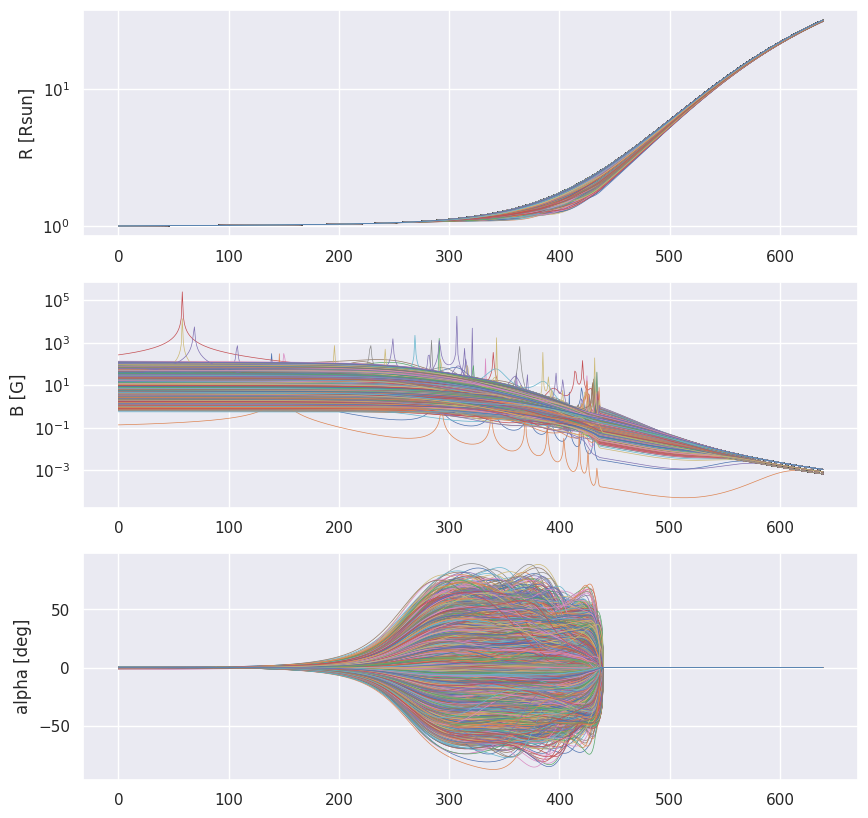

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [6]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)


scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())
# scaler.fit(scaled_flows)


(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.835765     0.244366
1  0.002002  0.835706     0.244547
2  0.004004  0.835646     0.244730
3  0.005636  0.835586     0.244918
4  0.008008  0.835526     0.245108


# Magnetic Field - B [G]

In [7]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]


array([0.83576521, 0.83570564, 0.83564594, 0.83558612, 0.83552618])

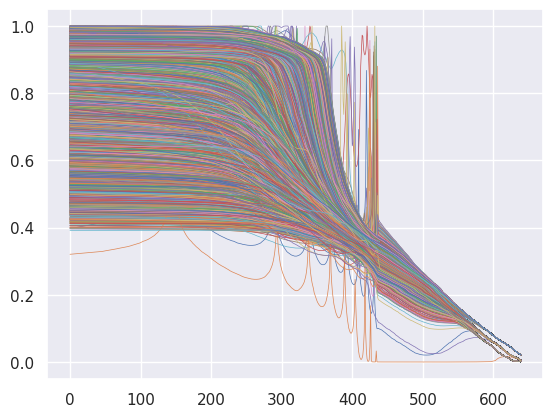

In [8]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)


## SOM

In [9]:
# rule of thumb number of clusters for SOM is the sqrt of the sqrt of the number of data points
som_x = som_y = 2
som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)

train_x = list(scaled_magnetic)

som.random_weights_init(train_x)
som.train(train_x, 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.8194857787341318


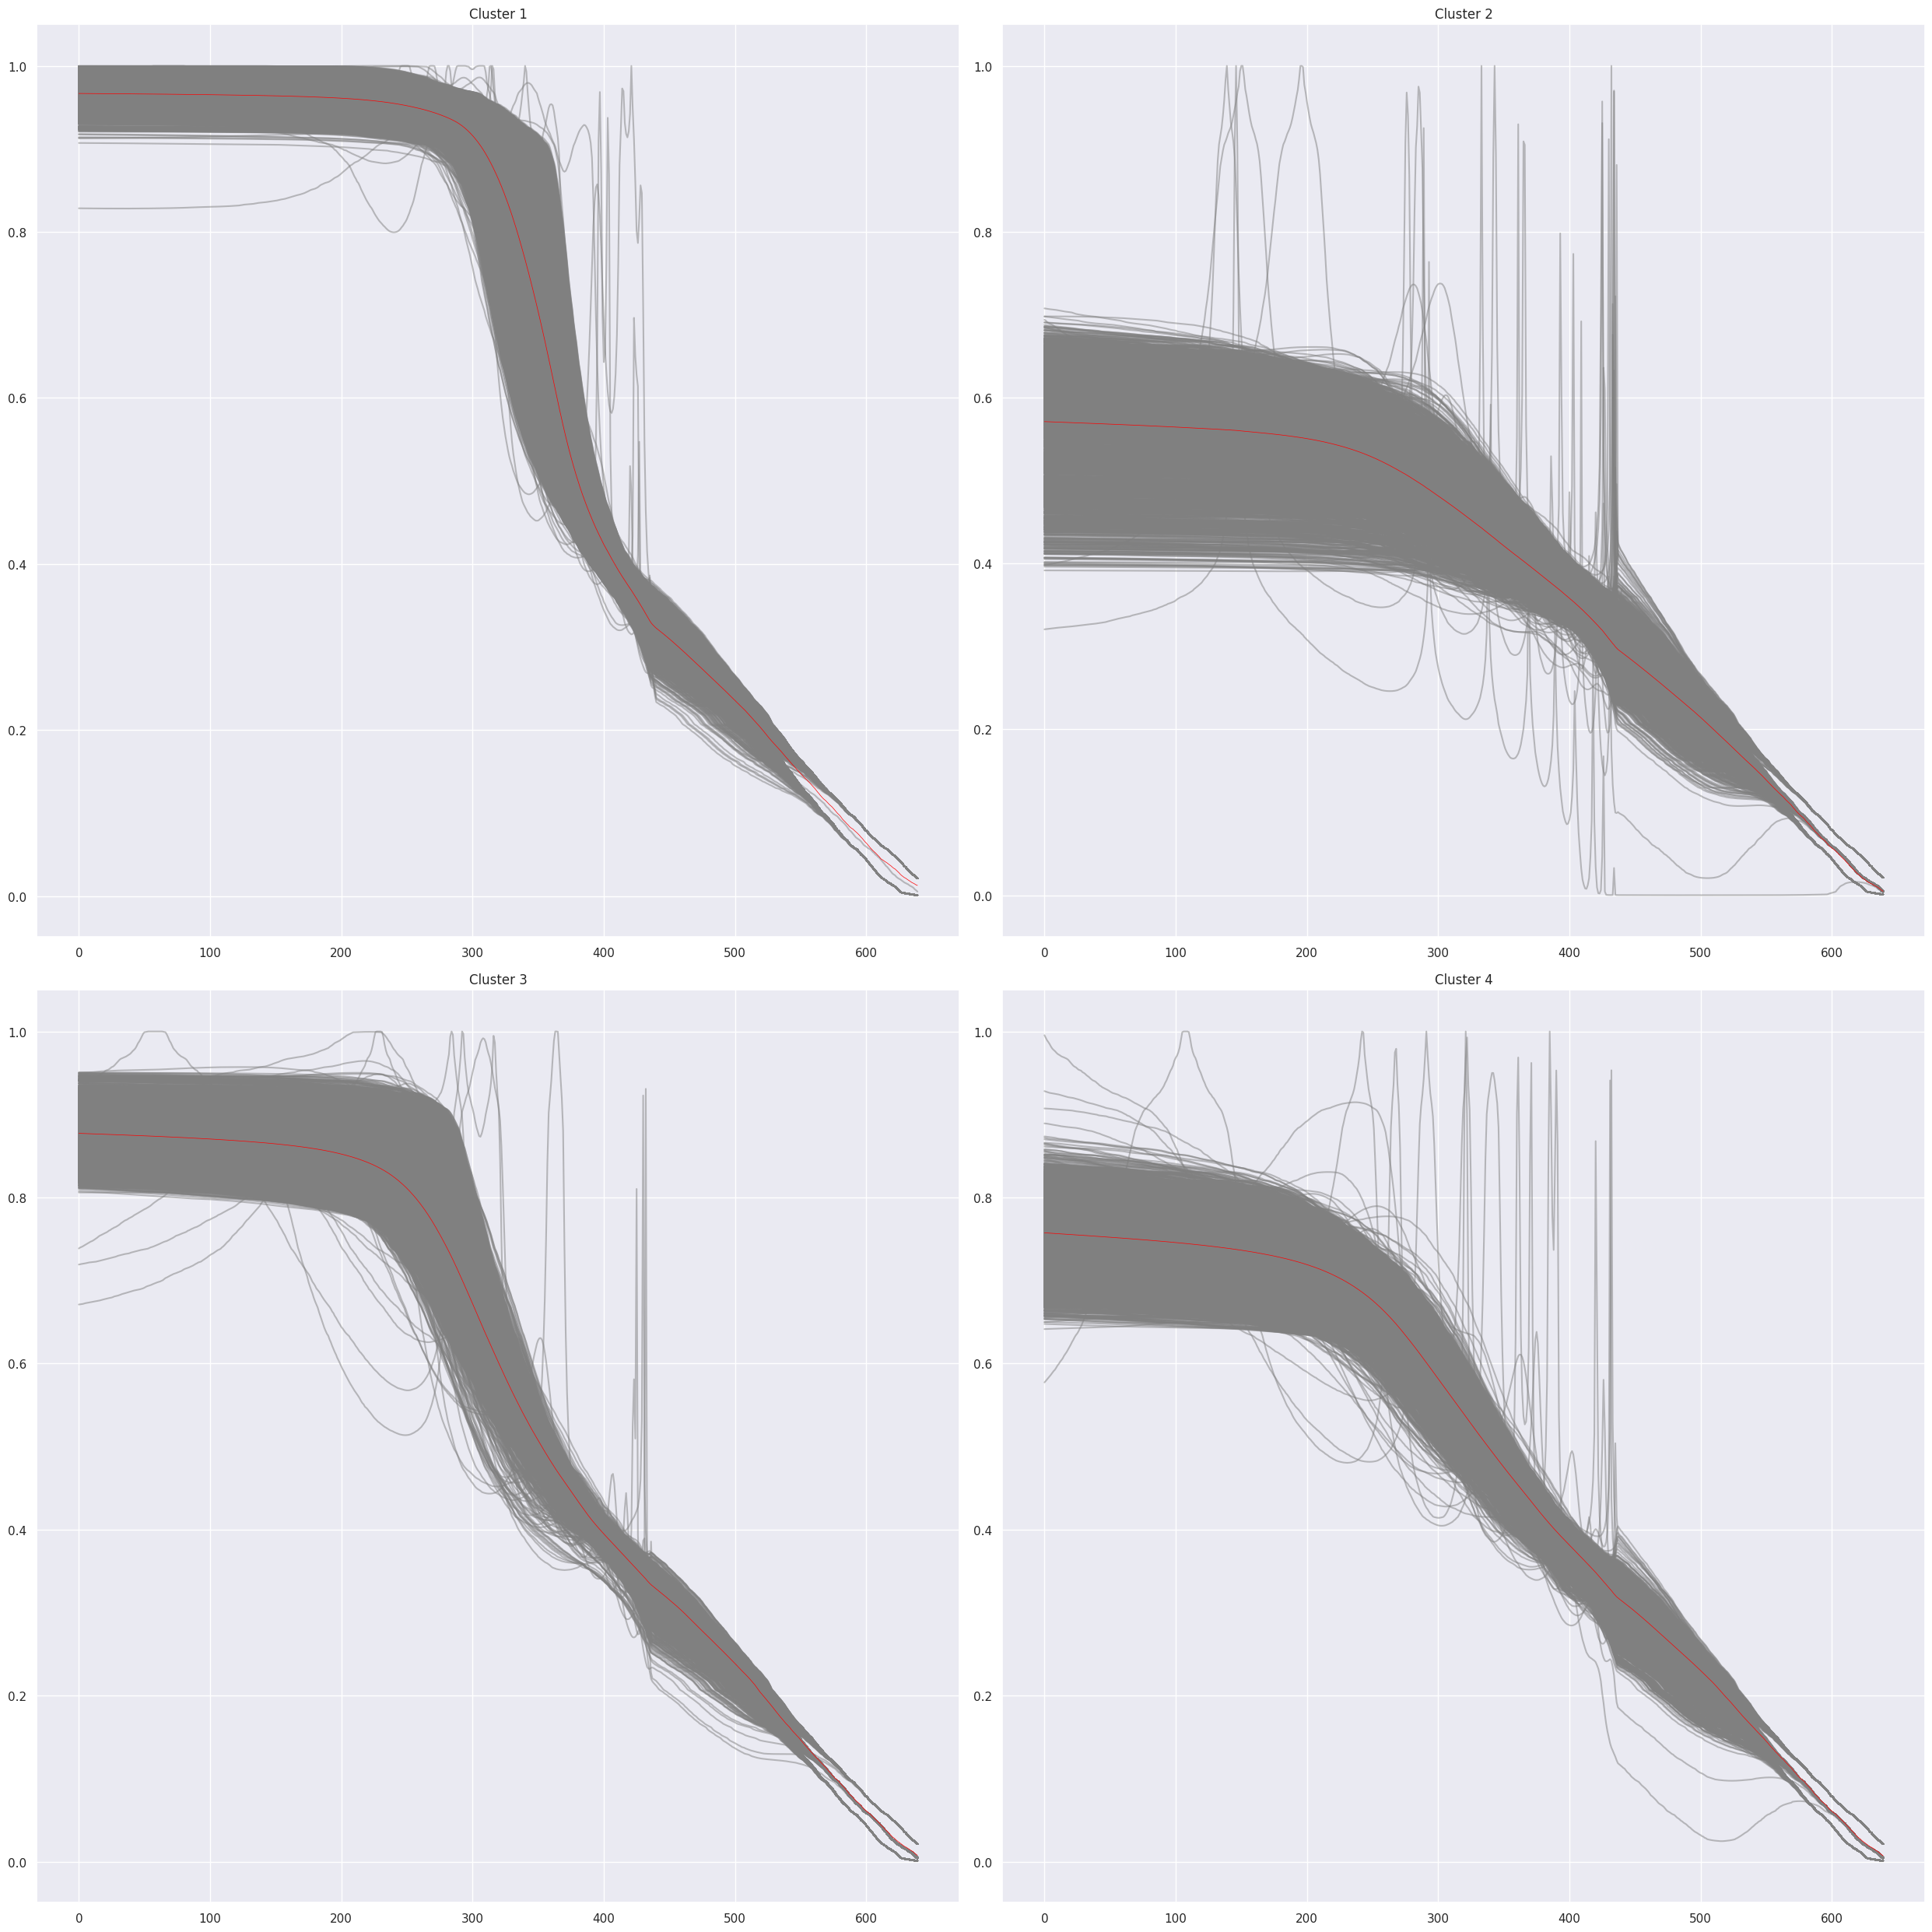

In [10]:
win_map = som.win_map(train_x)
plot_som_results(som_x, som_y, win_map)

### Original data clusters

(4, 2)


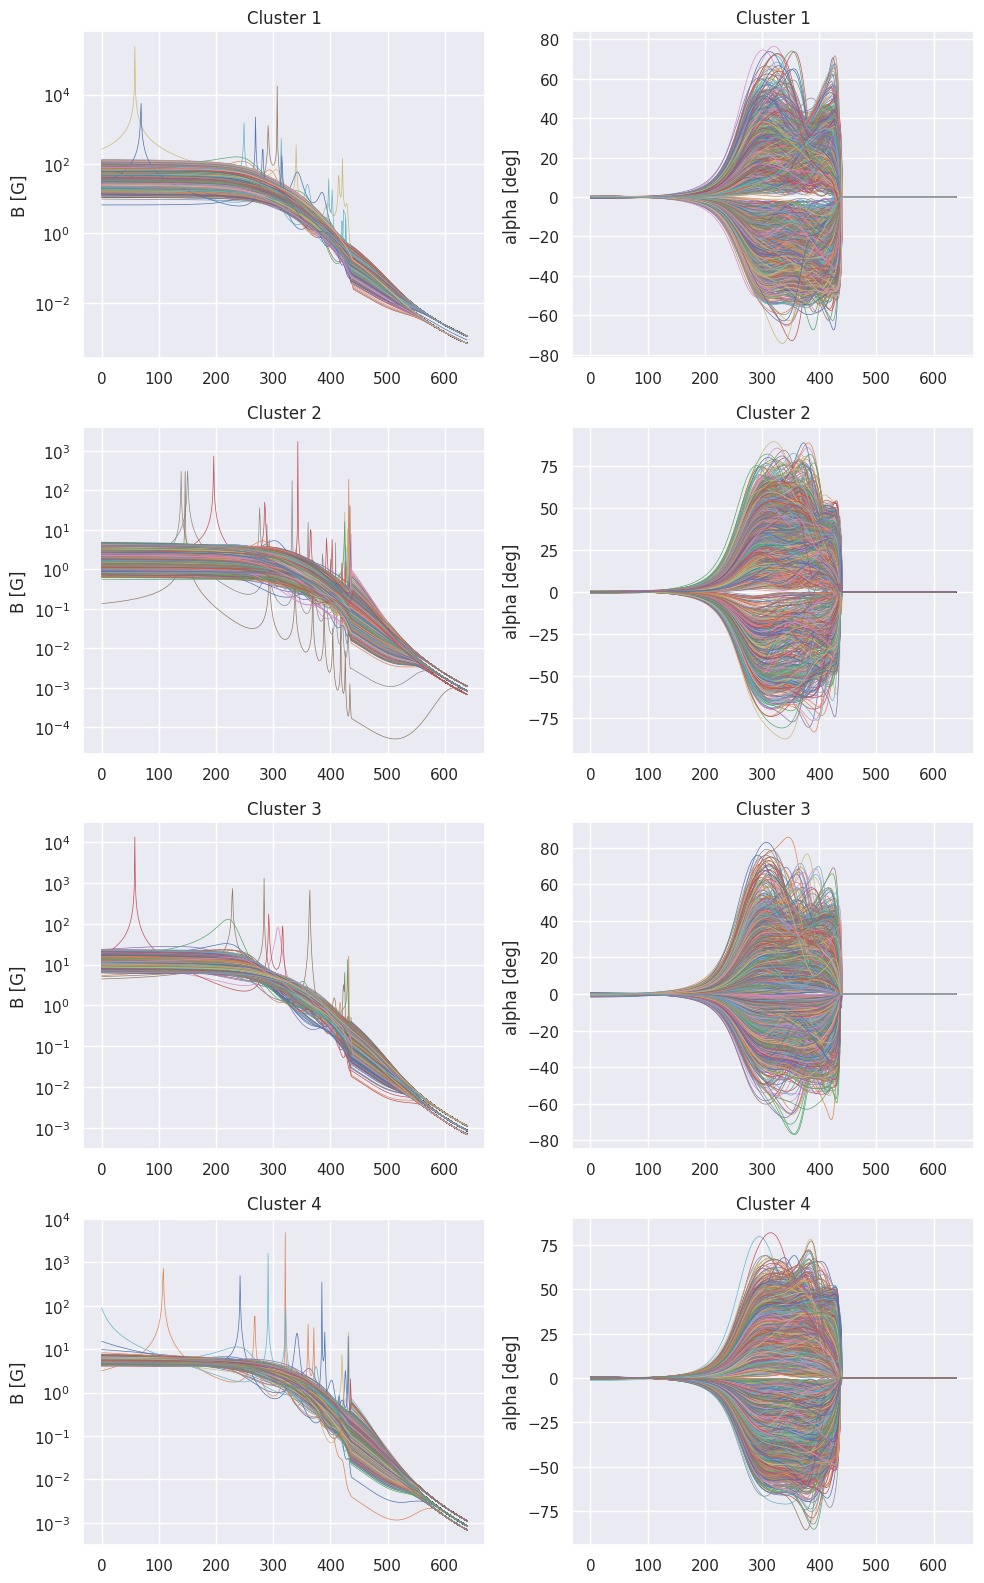

In [11]:
# display unscaled data into clusters
filenames = list(flows_dict.keys())

magnetic_clusters = OrderedDict()
for idx, scaled in enumerate(scaled_magnetic):
    winner_node = som.winner(scaled)
    magnetic_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])

nclusters = max(magnetic_clusters.keys())
plot_unscaled_clusters(magnetic_clusters, nclusters, flows_dict, flow_columns[1:], yscale={'B [G]': 'log'})


### Cluster Distributions

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

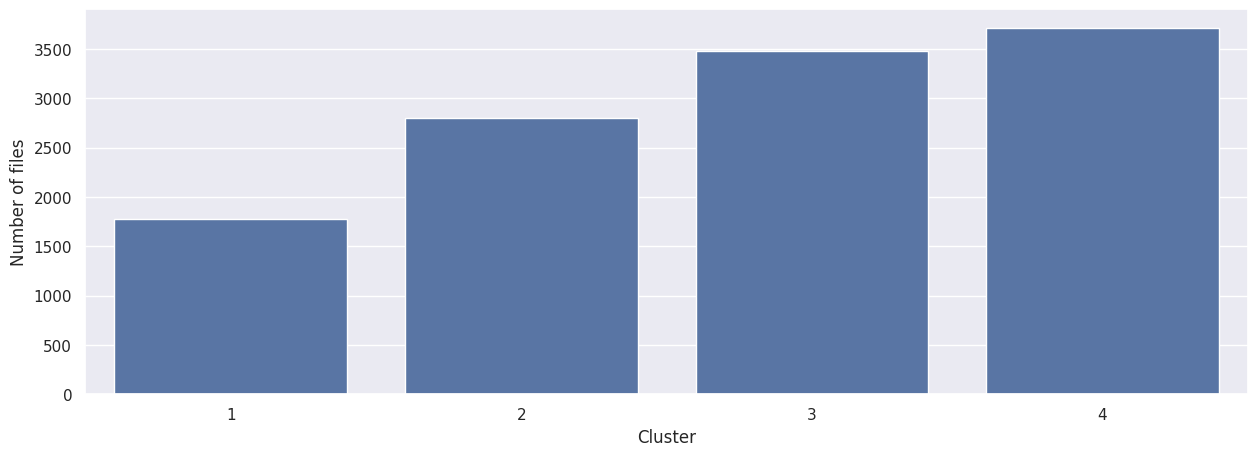

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
bp = sns.barplot(x=list(magnetic_clusters.keys()), y=[len(v) for v in magnetic_clusters.values()], ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [13]:
# %%capture
# subdir = OUT_DIR / 'mag'
# if not subdir.exists():
#     subdir.mkdir()
    
# train_x = list(scaled_magnetic)
# for i in range(2, 6):
#     som_x = som_y = i
#     som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)
#     som.random_weights_init(train_x)
#     som.train(train_x, 50000, verbose=True)
    
#     win_map = som.win_map(train_x)
#     plot_som_results(som_x, som_y, win_map, save_path=subdir / f'scaled_{i**2}.png')
    
#     # display unscaled data into clusters
#     filenames = list(flows_dict.keys())

#     mag_clusters = OrderedDict()
#     for idx, scaled in enumerate(scaled_magnetic):
#         winner_node = som.winner(scaled)
#         mag_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])
    
#     nclusters = max(mag_clusters.keys())
#     plot_unscaled_clusters(mag_clusters, nclusters, flows_dict,
#                         flow_columns[1:], save_path=subdir / f'unscaled{i**2}.png', yscale={'B [G]': 'log'})

# gc.collect()
        

# Flux Tube Inclination - alpha [deg]

In [14]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.24436587, 0.24454652, 0.24473047, 0.24491776, 0.24510844])

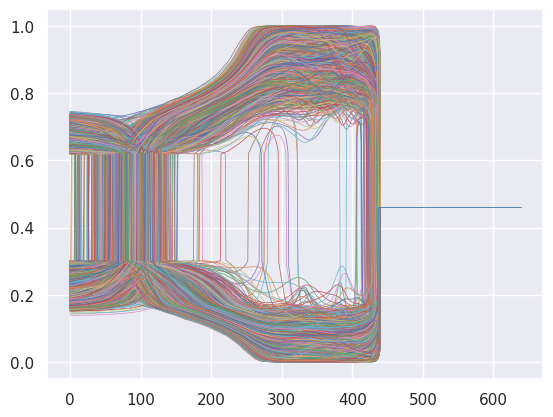

In [15]:
# plot scaled magnetic field
for a_line in scaled_alpha:
    plt.plot(a_line, linewidth=0.5)

plt.yscale('linear')

## SOM

In [16]:
# rule of thumb number of clusters for SOM is the sqrt of the sqrt of the number of data points
som_x = som_y = 2
som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)

train_x = list(scaled_alpha)

som.random_weights_init(train_x)
som.train(train_x, 50000, verbose=True)

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.1484724112565963


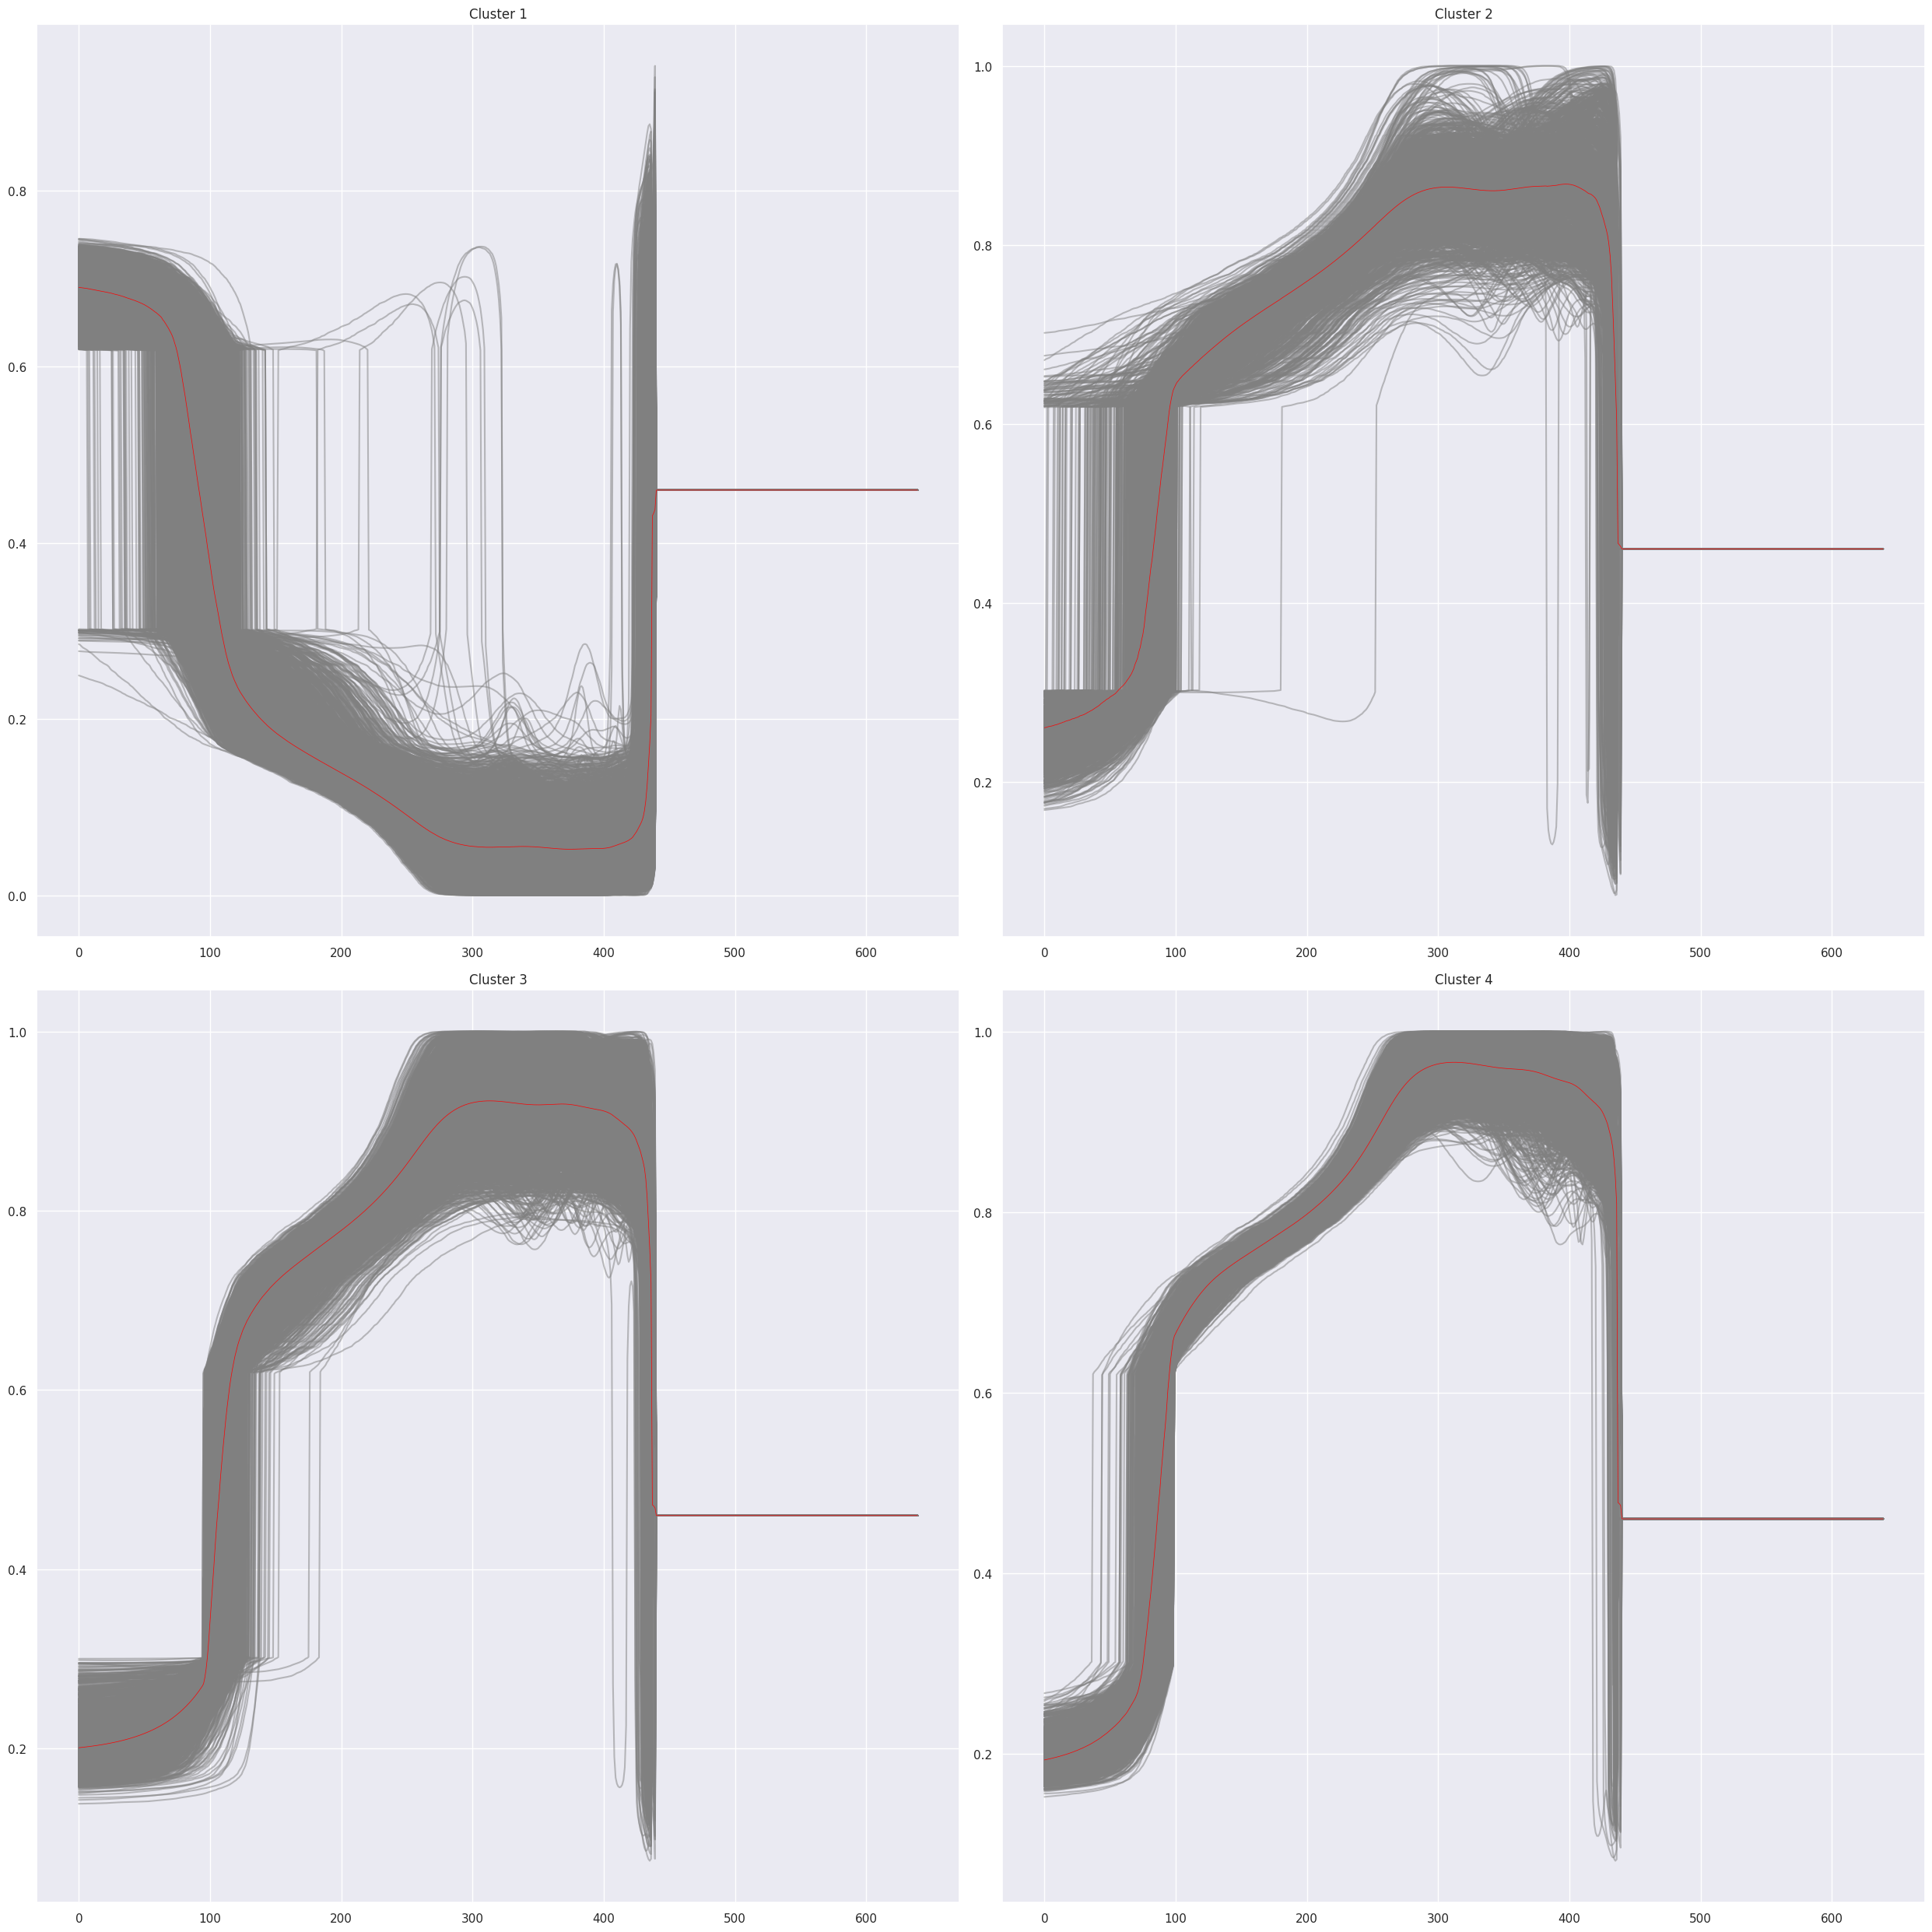

In [17]:
win_map = som.win_map(train_x)
plot_som_results(som_x, som_y, win_map)

### Original Data Clusters

(4, 2)


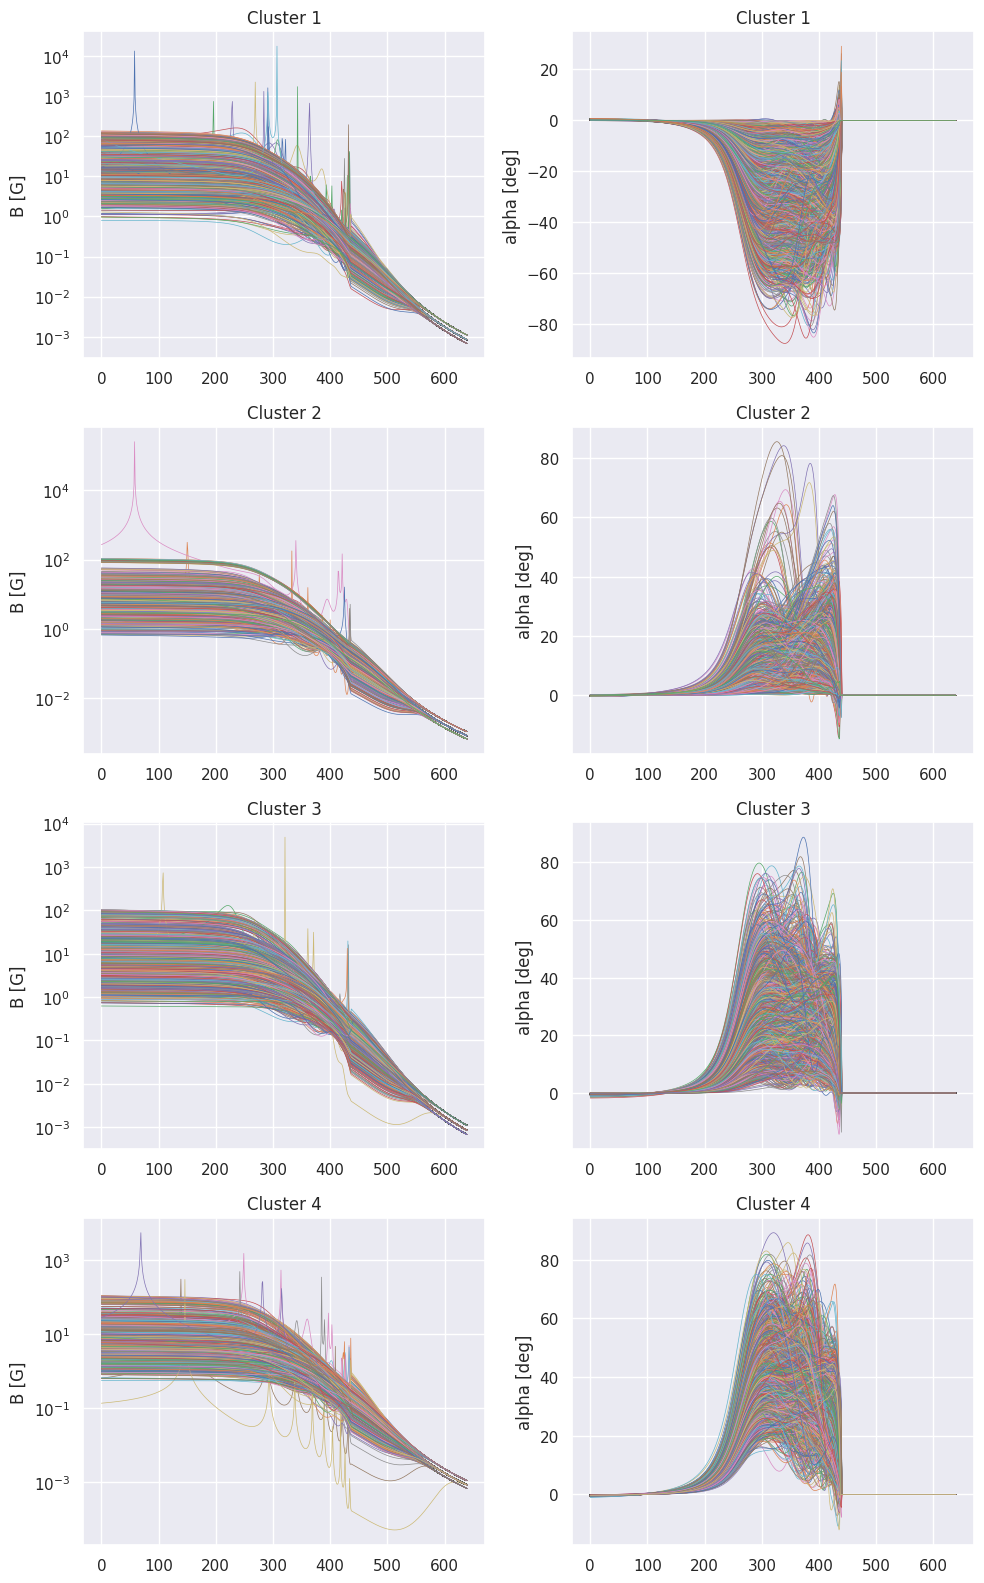

In [18]:
# display unscaled data into clusters
filenames = list(flows_dict.keys())

alpha_clusters = OrderedDict()
for idx, scaled in enumerate(scaled_alpha):
    winner_node = som.winner(scaled)
    alpha_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])

nclusters = max(alpha_clusters.keys())
plot_unscaled_clusters(alpha_clusters, nclusters, flows_dict, flow_columns[1:], yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

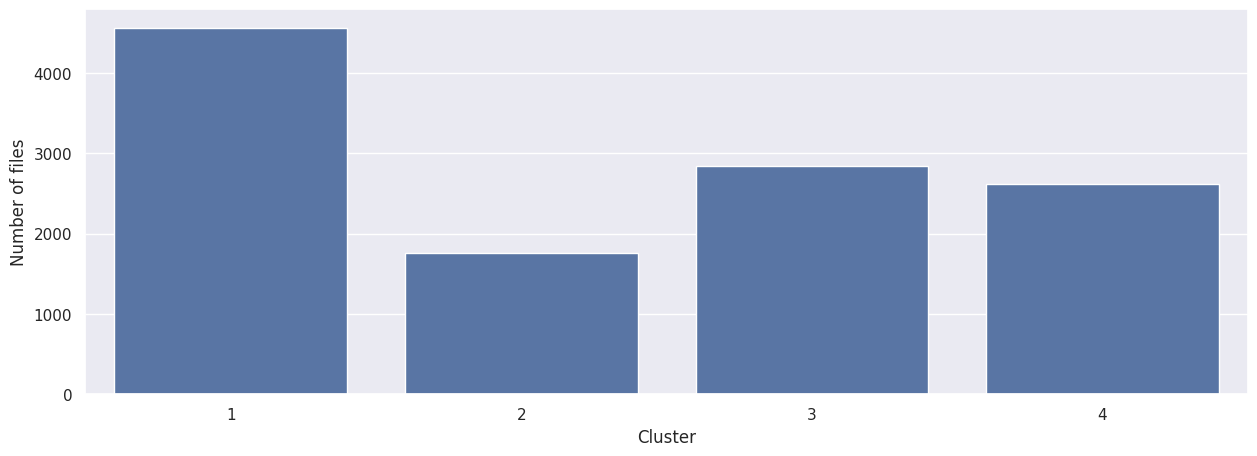

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
bp = sns.barplot(x=list(alpha_clusters.keys()), y=[len(v) for v in alpha_clusters.values()], ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [20]:
# %%capture
# subdir = OUT_DIR / 'alpha'
# if not subdir.exists():
#     subdir.mkdir()
    
# train_x = list(scaled_alpha)
# for i in range(2, 6):
#     som_x = som_y = i
#     som = MiniSom(som_x, som_y, 640, sigma=0.3, learning_rate = 0.1)
#     som.random_weights_init(train_x)
#     som.train(train_x, 50000, verbose=True)
    
        
#     win_map = som.win_map(train_x)
#     plot_som_results(som_x, som_y, win_map, save_path=subdir / f'scaled_{i**2}.png')
    
#     # display unscaled data into clusters
#     filenames = list(flows_dict.keys())

#     alpha_clusters = OrderedDict()
#     for idx, scaled in enumerate(scaled_alpha):
#         winner_node = som.winner(scaled)
#         alpha_clusters.setdefault(winner_node[0]*som_y + winner_node[1] + 1, list()).append(filenames[idx])
    
#     nclusters = max(alpha_clusters.keys())
#     plot_unscaled_clusters(alpha_clusters, nclusters, flows_dict,
#                         flow_columns[1:], save_path=subdir / f'unscaled_{i**2}.png', yscale={'B [G]': 'log'})
        